In [2949]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from utils import zoll
from utils import nirs
from utils import misc

In [2950]:
# parameters
case_id = 1
step_id = 6

In [2951]:
case_str = str(case_id).zfill(5)
output_file = f'output/{case_str}_{step_id}.csv'
input_file = 'output/' + case_str + '_5.csv'

In [2952]:
# load data
df = pd.read_csv(input_file,
                 sep = ',',
                 na_values = ['-'],
                 parse_dates = ['Time'],
                 index_col = 'Time')
#mark_timestamp = df.loc[df['Mark'] == 1].index[0]

In [2953]:
# dropout
df['rSO2_dropout'] = np.where(df['Bad_rSO2_manual'] == 1, np.nan, df['rSO2'])
df['MAP_dropout'] = np.where(df['Bad_MAP_auto'] == 1, np.nan, df['MAP'])
df['MAP_dropout'] = np.where(df['Bad_MAP_manual'] == 1, np.nan, df['MAP_dropout'])

In [2954]:
# smooth rSO2 to match MAP
df['rSO2_dropout'] = df['rSO2_dropout'].rolling(10).mean()

In [2955]:
# resampling as per Ono, Joshi, Brady, Easley et al. 2012
rdf = pd.DataFrame()
rdf['rSO2'] = df['rSO2_dropout'].resample('10s').mean()
rdf['MAP'] = df['MAP_dropout'].resample('10s').mean()

In [2956]:
# compute COx
rdf['COx'] = rdf['rSO2'].rolling(30, center=True).corr(rdf['MAP'])
rdf['COx_right'] = rdf['rSO2'].rolling(30, center=False).corr(rdf['MAP'])

# Timeplots

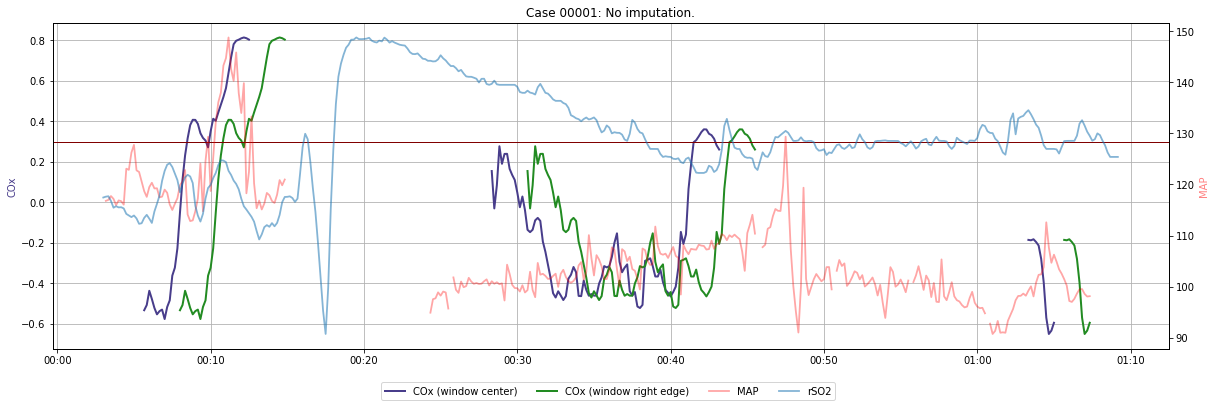

In [2957]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.set_ylabel('COx', color='darkslateblue')
ax1.plot(rdf.index, rdf['COx'], linewidth=2.0, color='darkslateblue', label='COx (window center)')
ax1.plot(rdf.index, rdf['COx_right'], linewidth=2.0, color='forestgreen', label='COx (window right edge)')
ax2 = ax1.twinx()
ax2.plot(rdf.index, rdf['MAP'], linewidth=1.8, alpha=0.35, color='red', label='MAP')
ax2.set_ylabel('MAP', color="red", alpha=0.5)
ax3 = ax1.twinx()
ax3.plot(rdf.index, rdf['rSO2'], linewidth=1.8, alpha=0.55, label='rSO2')
ax3.set_yticks([])
ax1.grid()
ax1.axhline(0.3, linewidth=1, color="maroon")
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
plt.title(f'Case {case_str}: No imputation.')
fig.legend(loc="lower center", ncol=4)
plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)

In [2958]:
# interpolate
df['MAP_interpolated'] = df['MAP_dropout'].interpolate(limit_area='inside')
df['rSO2_interpolated'] = df['rSO2_dropout'].interpolate(limit_area='inside')

In [2959]:
# smooth
df['MAP_smooth'] = df['MAP_interpolated'].rolling(300).mean()
df['rSO2_smooth'] = df['rSO2_interpolated'].rolling(300).mean()

In [2960]:
# resampling as per Ono, Joshi, Brady, Easley et al. 2012
rdf['rSO2_interpolated'] = df['rSO2_interpolated'].resample('10s').mean()
rdf['MAP_interpolated'] = df['MAP_interpolated'].resample('10s').mean()
rdf['rSO2_smooth'] = df['rSO2_smooth'].resample('10s').mean()
rdf['MAP_smooth'] = df['MAP_smooth'].resample('10s').mean()

In [2961]:
# compute COx
rdf['COx_interpolated'] = rdf['rSO2_interpolated'].rolling(30, center=True).corr(rdf['MAP_interpolated'])
rdf['COx_interpolated_right'] = rdf['rSO2_interpolated'].rolling(30, center=False).corr(rdf['MAP_interpolated'])

rdf.replace([np.inf, -np.inf], 0, inplace=True)   # see https://github.com/pandas-dev/pandas/issues/29264

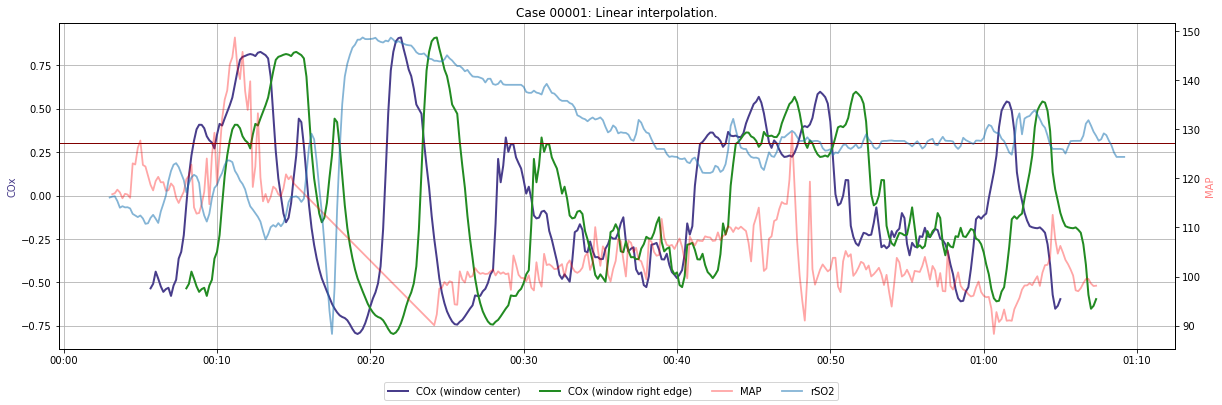

In [2962]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.set_ylabel('COx', color='darkslateblue')
ax1.plot(rdf.index, rdf['COx_interpolated'], linewidth=2.0, color='darkslateblue', label='COx (window center)')
ax1.plot(rdf.index, rdf['COx_interpolated_right'], linewidth=2.0, color='forestgreen', label='COx (window right edge)')
ax2 = ax1.twinx()
ax2.plot(rdf.index, rdf['MAP_interpolated'], linewidth=1.8, alpha=0.35, color='red', label='MAP')
ax2.set_ylabel('MAP', color="red", alpha=0.5)
ax3 = ax1.twinx()
ax3.plot(rdf.index, rdf['rSO2_interpolated'], linewidth=1.8, alpha=0.55, label='rSO2')
ax3.set_yticks([])
ax1.grid()
ax1.axhline(0.3, linewidth=1, color="maroon")
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
plt.title(f'Case {case_str}: Linear interpolation.')
fig.legend(loc="lower center", ncol=4)
plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)

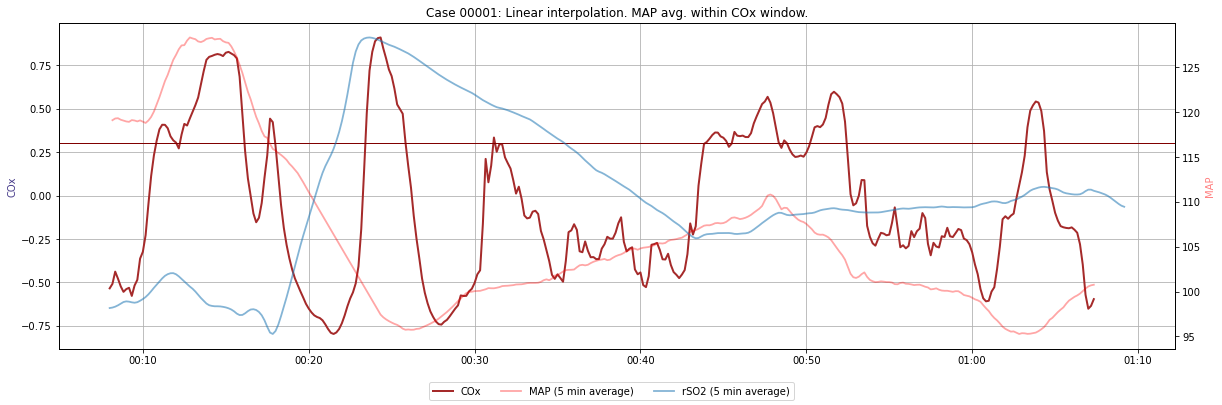

In [2963]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.set_ylabel('COx', color='darkslateblue')
ax1.plot(rdf.index, rdf['COx_interpolated_right'], linewidth=2.0, color='brown', label='COx')
ax2 = ax1.twinx()
ax2.plot(rdf.index, rdf['MAP_smooth'], linewidth=1.8, alpha=0.35, color='red', label='MAP (5 min average)')
ax2.set_ylabel('MAP', color="red", alpha=0.5)
ax3 = ax1.twinx()
ax3.plot(rdf.index, rdf['rSO2_smooth'], linewidth=1.8, alpha=0.55, label='rSO2 (5 min average)')
ax3.set_yticks([])
ax1.grid()
ax1.axhline(0.3, linewidth=1, color="maroon")
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
plt.title(f'Case {case_str}: Linear interpolation. MAP avg. within COx window.')
fig.legend(loc="lower center", ncol=3)
plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)

In [2964]:
def custom_round(x, base=5):
    if (np.isnan(x)): return np.nan
    return base * round(float(x)/base)

In [2965]:
rdf['MAP_bins'] = rdf['MAP_interpolated'].apply(lambda x: custom_round(x))
rdf['MAP_bins_smooth'] = rdf['MAP_smooth'].apply(lambda x: custom_round(x))

In [2966]:
binned_df = rdf.groupby(['MAP_bins']).mean()
binned_smooth_df = rdf.groupby(['MAP_bins_smooth']).mean()

In [2967]:
binned_df['COx_smooth'] = binned_smooth_df['COx_interpolated_right']
binned_df = binned_df[['COx_interpolated', 'COx_interpolated_right', 'COx_smooth']].dropna(how='all')

In [2968]:
counts = pd.DataFrame(index=binned_df.index)
counts['Window center'] = rdf[['MAP_bins', 'COx_interpolated']].dropna().MAP_bins.value_counts()
counts['Window right'] = rdf[['MAP_bins', 'COx_interpolated_right']].dropna().MAP_bins.value_counts()
counts['Window average'] = rdf[['MAP_bins_smooth', 'COx_interpolated_right']].dropna().MAP_bins_smooth.value_counts()
counts.fillna(0, inplace=True)
counts.index = counts.index.astype(int)
counts = counts.sort_index().astype(int)

In [2969]:
tdf = rdf[['MAP_bins', 'COx_interpolated']].dropna(how='all')
tdf.reset_index(inplace=True)
tdf = tdf.pivot(index='Time', columns='MAP_bins', values='COx_interpolated')
tdf = tdf.reindex(columns=binned_df.index)
sem = tdf.sem().fillna(0).to_numpy()
sem_center = np.array([len(sem)*[0], sem])
iqr_center = tdf.quantile([0.25, 0.75])
iqr_center = iqr_center.transpose()[0.75] - iqr_center.transpose()[0.25]
#range_center = np.nan_to_num(abs(tdf.quantile([0, 1]).to_numpy() - tdf.mean().to_numpy()))

tdf = rdf[['MAP_bins', 'COx_interpolated_right']].dropna(how='all')
tdf.reset_index(inplace=True)
tdf = tdf.pivot(index='Time', columns='MAP_bins', values='COx_interpolated_right')
tdf = tdf.reindex(columns=binned_df.index)
sem = tdf.sem().fillna(0).to_numpy()
sem_right = np.array([len(sem)*[0], sem])
iqr_right = tdf.quantile([0.25, 0.75])
iqr_right = iqr_right.transpose()[0.75] - iqr_right.transpose()[0.25]
#range_right = np.nan_to_num(abs(tdf.quantile([0, 1]).to_numpy() - tdf.mean().to_numpy()))

tdf = rdf[['MAP_bins_smooth', 'COx_interpolated_right']].dropna(how='all')
tdf = tdf.dropna(subset=['MAP_bins_smooth'])
tdf.reset_index(inplace=True)
tdf = tdf.pivot(index='Time', columns='MAP_bins_smooth', values='COx_interpolated_right')
tdf = tdf.reindex(columns=binned_df.index)
sem = tdf.sem().fillna(0).to_numpy()
sem_average = np.array([len(sem)*[0], sem])
iqr_average = tdf.quantile([0.25, 0.75])
iqr_average = iqr_average.transpose()[0.75] - iqr_average.transpose()[0.25]
#range_average = np.nan_to_num(abs(tdf.quantile([0, 1]).to_numpy() - tdf.mean().to_numpy()))

# COx analysis

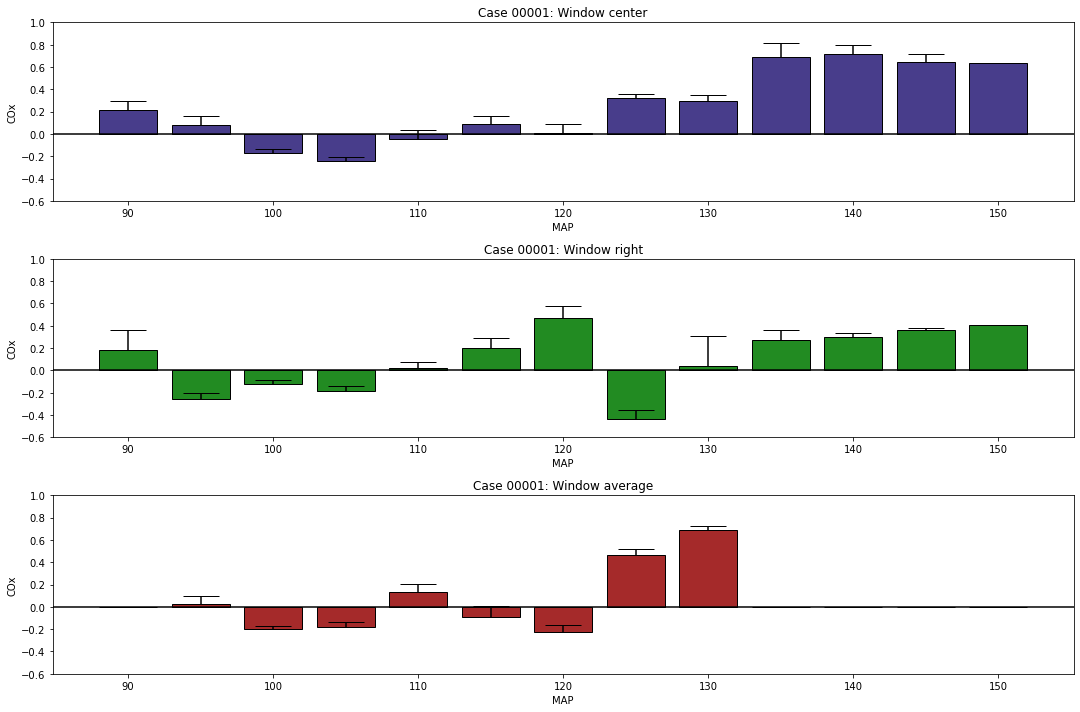

In [2970]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15.2,10))

width = 4

ax1.bar(binned_df.index, binned_df['COx_interpolated'].fillna(0), yerr=sem_center, capsize=18, label='Window center', color='darkslateblue', width=width, linewidth=1, edgecolor='black')
ax2.bar(binned_df.index, binned_df['COx_interpolated_right'].fillna(0), yerr=sem_right, capsize=18, label='Window right', color='forestgreen', width=width, linewidth=1, edgecolor='black')
ax3.bar(binned_df.index, binned_df['COx_smooth'].fillna(0), yerr=sem_average, capsize=18, label='Window average', color='brown', width=width, linewidth=1, edgecolor='black')

ax1.set_title(f'Case {case_str}: Window center')
ax1.set_xlabel('MAP')
ax1.set_ylabel('COx')
ax1.set_ylim(-0.6, 1)
ax1.axhline(0, linewidth=None, color="black")
ax2.set_title(f'Case {case_str}: Window right')
ax2.set_xlabel('MAP')
ax2.set_ylabel('COx')
ax2.set_ylim(-0.6, 1)
ax2.axhline(0, linewidth=None, color="black")
ax3.set_title(f'Case {case_str}: Window average')
ax3.set_xlabel('MAP')
ax3.set_ylabel('COx')
ax3.set_ylim(-0.6, 1)
ax3.axhline(0, linewidth=None, color="black")
ax3.set_xlim(ax1.get_xlim())
#fig.legend(loc="lower left", ncol=3)
plt.tight_layout()
plt.savefig(f'reports/images/{step_id}_{case_str}_03.png', bbox_inches='tight', pad_inches=0.1)

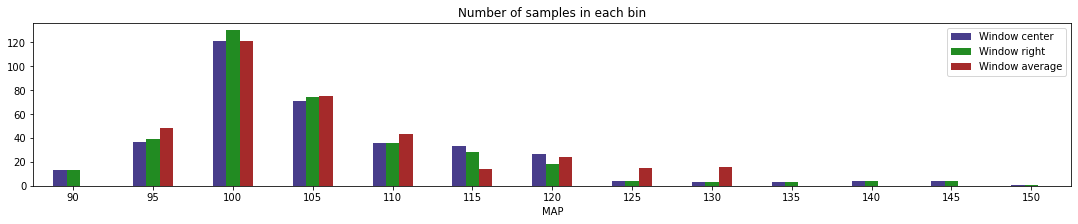

In [2971]:
_ = counts.plot.bar(figsize=(18.6,3), color=('darkslateblue', 'forestgreen', 'brown'), title="Number of samples in each bin", xlabel="MAP", rot=0)

In [2972]:
counts.transpose()

MAP_bins,90,95,100,105,110,115,120,125,130,135,140,145,150
Window center,13,37,121,71,36,33,27,4,3,3,4,4,1
Window right,13,39,130,74,36,28,18,4,3,3,4,4,1
Window average,0,48,121,75,43,14,24,15,16,0,0,0,0


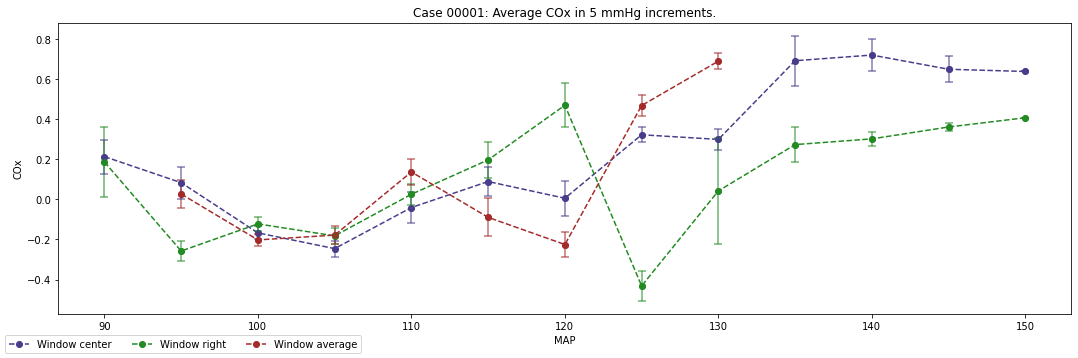

In [2973]:
fig, ax = plt.subplots(figsize=(15,5))

ax.errorbar(binned_df.index, binned_df['COx_interpolated'], yerr=sem_center[1], elinewidth=2, capsize=4, capthick=2, alpha=0.5, c='darkslateblue', fmt='o')
ax.plot(binned_df.index, binned_df['COx_interpolated'], label='Window center', marker='o', c='darkslateblue', linestyle='dashed')

ax.errorbar(binned_df.index, binned_df['COx_interpolated_right'], yerr=sem_right[1], elinewidth=2, capsize=4, capthick=2, alpha=0.5, c='forestgreen', fmt='o')
ax.plot(binned_df.index, binned_df['COx_interpolated_right'], label='Window right', marker='o', c='forestgreen', linestyle='dashed')

ax.errorbar(binned_df.index, binned_df['COx_smooth'], yerr=sem_average[1], elinewidth=2, capsize=4, capthick=2, alpha=0.5, c='brown', fmt='o')
ax.plot(binned_df.index, binned_df['COx_smooth'], label='Window average', marker='o', c='brown', linestyle='dashed')

ax.set_title(f'Case {case_str}: Average COx in 5 mmHg increments.')
ax.set_xlabel('MAP')
ax.set_ylabel('COx')
#ax.axhline(0.3, linewidth=0.5, color="red")
fig.legend(loc="lower left", ncol=3)
plt.tight_layout()
plt.savefig(f'reports/images/{step_id}_{case_str}_03.png', bbox_inches='tight', pad_inches=0.1)

In [2974]:
if False:
    fig, ax = plt.subplots(figsize=(15,5))

    width = 1

    ax.bar(binned_df.index-width, binned_df['COx_interpolated'], yerr=sem_center, capsize=4, label='Window center', color='darkslateblue', width=width, linewidth=1, edgecolor='black')
    ax.bar(binned_df.index, binned_df['COx_interpolated_right'], yerr=sem_right, capsize=4, label='Window right', color='forestgreen', width=width, linewidth=1, edgecolor='black')
    ax.bar(binned_df.index+width, binned_df['COx_smooth'], yerr=sem_average, capsize=4, label='Window average', color='brown', width=width, linewidth=1, edgecolor='black')

    plt.title(f'Case {case_str}. Average COx in 10 mmHg increments.')
    ax.set_xlabel('MAP')
    ax.set_ylabel('COx')
    ax.axhline(0, linewidth=None, color="black")
    fig.legend(loc="lower left", ncol=3)
    plt.tight_layout()
    plt.savefig(f'reports/images/{step_id}_{case_str}_03.png', bbox_inches='tight', pad_inches=0.1)

# Distributions

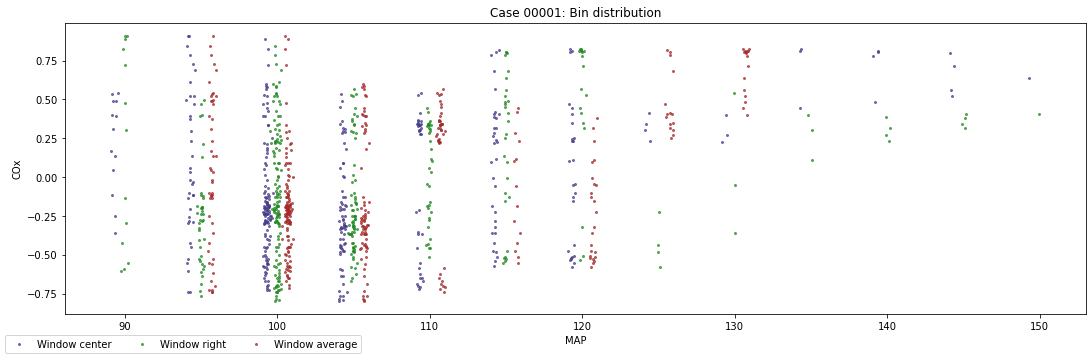

In [2975]:
fig, ax = plt.subplots(figsize=(15.2,5))

ax.plot(rdf['MAP_bins'] - 0.7 + np.random.randn(len(rdf['MAP_bins']))*0.13, rdf['COx_interpolated'], alpha=0.7, label='Window center', marker='.', markersize=4, c='darkslateblue', linestyle='None')
ax.plot(rdf['MAP_bins'] + 0 + np.random.randn(len(rdf['MAP_bins']))*0.13, rdf['COx_interpolated_right'], alpha=0.7, label='Window right', marker='.', markersize=4, c='forestgreen', linestyle='None')
ax.plot(rdf['MAP_bins_smooth'] + 0.7 + np.random.randn(len(rdf['MAP_bins_smooth']))*0.13, rdf['COx_interpolated_right'], alpha=0.7, label='Window average', marker='.', markersize=4, c='brown', linestyle='None')

ax.set_title(f'Case {case_str}: Bin distribution')
ax.set_xlabel('MAP')
ax.set_ylabel('COx')
fig.legend(loc="lower left", ncol=3)
plt.tight_layout()
#plt.savefig(f'reports/images/{step_id}_{case_str}_03.png', bbox_inches='tight', pad_inches=0.1)

## Window center

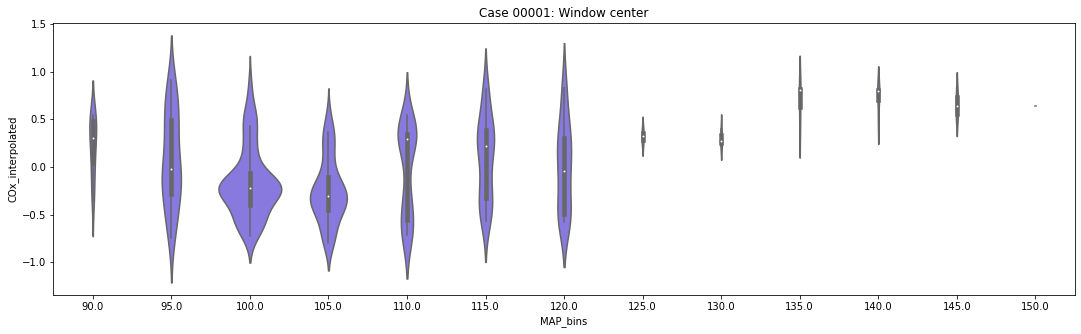

In [3008]:
fig, ax = plt.subplots(figsize=(18.3, 5))
sns.violinplot(x='MAP_bins', y='COx_interpolated', data=rdf, scale="count", color='mediumslateblue', ax=ax).set_title(f'Case {case_str}: Window center')
plt.savefig(f'reports/images/{step_id}_{case_str}_02.png', bbox_inches='tight', pad_inches=0.1)

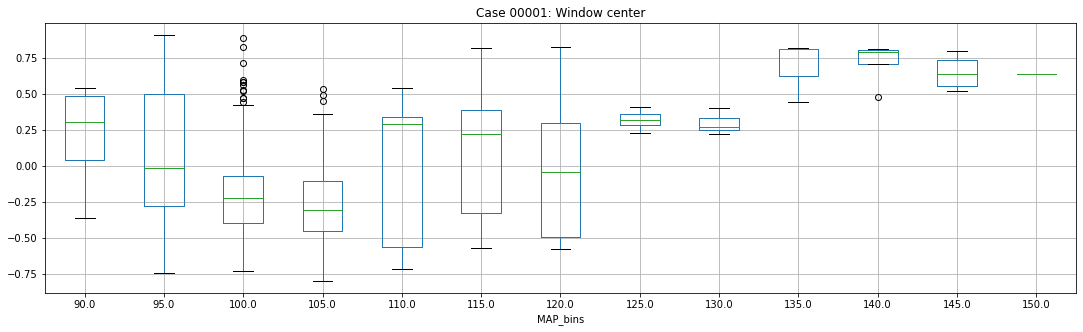

In [2977]:
rdf.boxplot(column = 'COx_interpolated', by = 'MAP_bins', figsize = (17.9, 5))
plt.title(f'Case {case_str}: Window center')
_ = plt.suptitle("")
#plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)

In [2978]:
mean_iqr = iqr_center.mean()
quant = rdf['COx_interpolated'].quantile([0.25, 0.75]).to_numpy()
cox_iqr = quant[1] - quant[0]
print(f'Mean of within-bin IQR : {mean_iqr:.02f}')
print(f'COx total IQR          : {cox_iqr:.02f}')

Mean of within-category IQR : 0.38
COx total IQR               : 0.69


## Window right

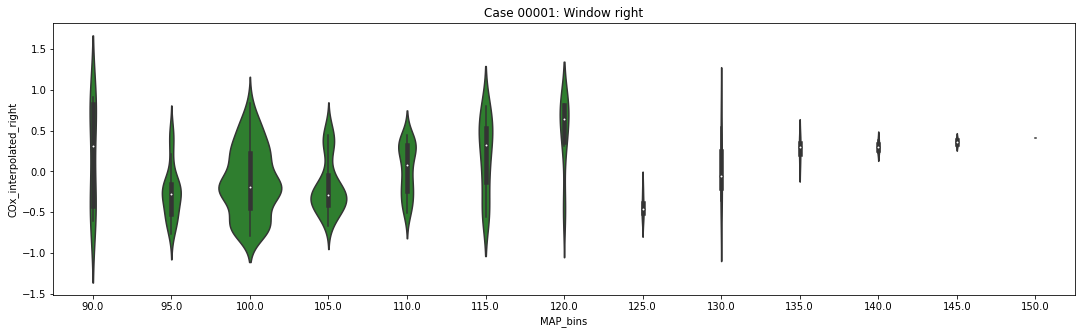

In [3005]:
fig, ax = plt.subplots(figsize=(18.3, 5))
sns.violinplot(x='MAP_bins', y='COx_interpolated_right', data=rdf, scale="count", color='forestgreen', ax=ax).set_title(f'Case {case_str}: Window right')
plt.savefig(f'reports/images/{step_id}_{case_str}_02.png', bbox_inches='tight', pad_inches=0.1)

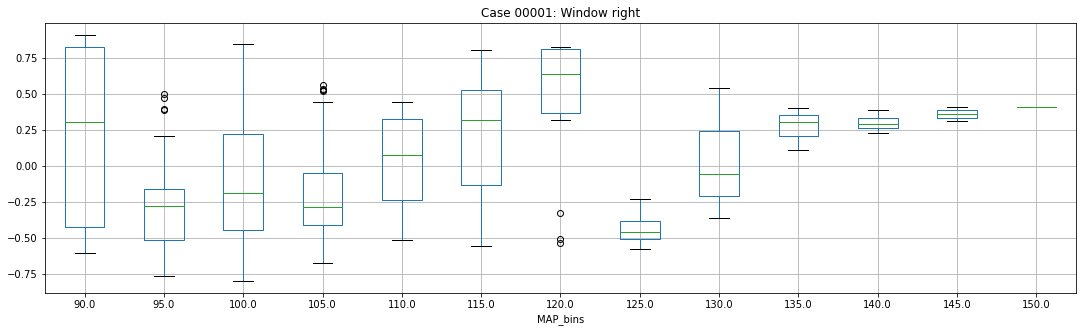

In [2980]:
rdf.boxplot(column = 'COx_interpolated_right', by = 'MAP_bins', figsize = (17.9, 5))
plt.title(f'Case {case_str}: Window right')
_ = plt.suptitle("")
#plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)

In [2981]:
mean_iqr = iqr_right.mean()
quant = rdf['COx_interpolated_right'].quantile([0.25, 0.75]).to_numpy()
cox_iqr = quant[1] - quant[0]
print(f'Mean of within-bin IQR : {mean_iqr:.02f}')
print(f'COx total IQR          : {cox_iqr:.02f}')

Mean of within-category IQR : 0.40
COx total IQR               : 0.69


## Window average

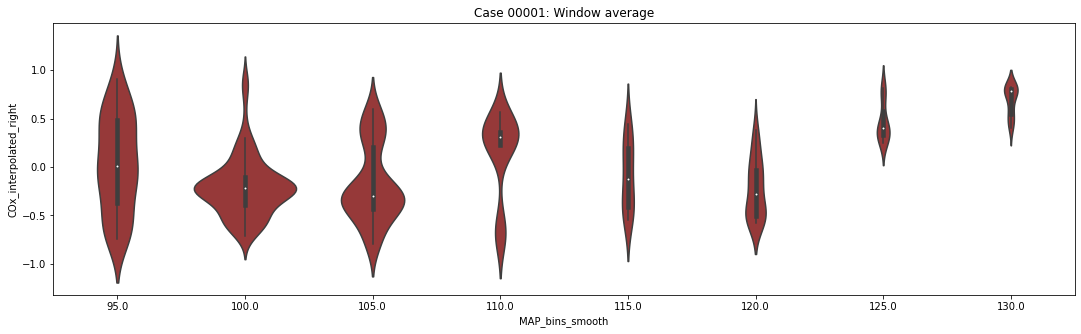

In [3006]:
fig, ax = plt.subplots(figsize=(18.3, 5))
sns.violinplot(x='MAP_bins_smooth', y='COx_interpolated_right', data=rdf, scale="count", color='brown', ax=ax).set_title(f'Case {case_str}: Window average')
plt.savefig(f'reports/images/{step_id}_{case_str}_02.png', bbox_inches='tight', pad_inches=0.1)

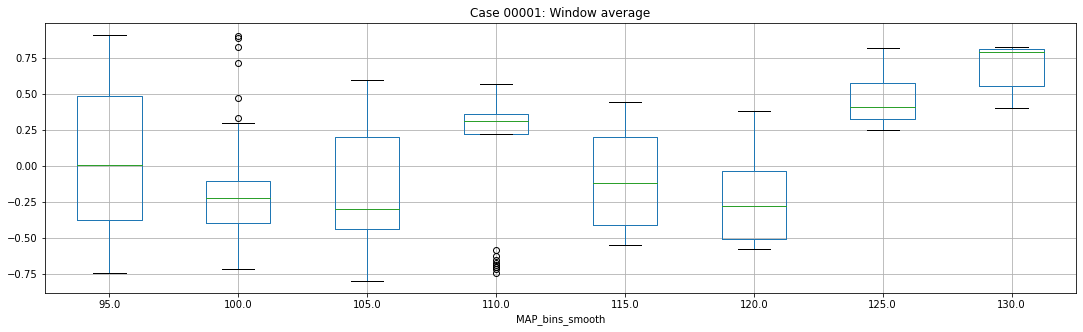

In [2983]:
rdf.boxplot(column = 'COx_interpolated_right', by = 'MAP_bins_smooth', figsize = (17.9, 5))
plt.title(f'Case {case_str}: Window average')
_ = plt.suptitle("")
#plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)

In [2984]:
mean_iqr = iqr_average.mean()
quant = rdf['COx_interpolated_right'].quantile([0.25, 0.75]).to_numpy()
cox_iqr = quant[1] - quant[0]
print(f'Mean of within-bin IQR : {mean_iqr:.02f}')
print(f'COx total IQR          : {cox_iqr:.02f}')

Mean of within-category IQR : 0.44
COx total IQR               : 0.69


# Statistics

In [2985]:
# compute statistics
cox_critical = (rdf['COx_interpolated'] >= 0.30).sum()
cox_defined = rdf['COx_interpolated'].count()
cox_over_03_center = cox_critical / cox_defined

cox_critical = (rdf['COx_interpolated_right'] >= 0.30).sum()
cox_defined = rdf['COx_interpolated_right'].count()
cox_over_03_right = cox_critical / cox_defined

print(f'COx above 0.3 threshold in {cox_over_03_center*100:.02f} % of defined datapoints')
#print(f'COx above threshold (window right)  : {cox_over_03_right:.02f}')

COx above 0.3 threshold in 26.89 % of defined datapoints


# MAP-rSO<sub>2</sub> plot

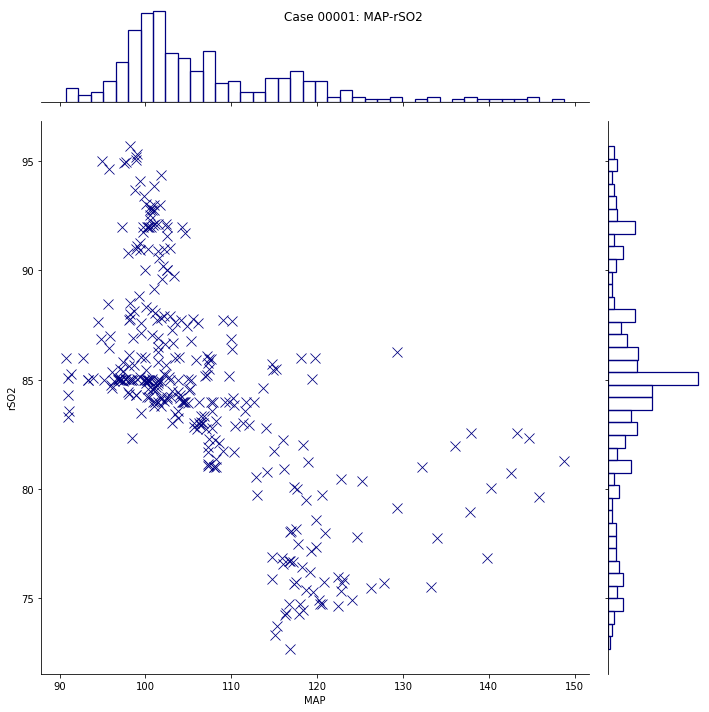

In [3003]:
tdf = rdf.dropna(subset=['MAP', 'rSO2'])
g = sns.jointplot(x="MAP", y="rSO2", data=tdf, kind='scatter', alpha=1, color="navy", height=10, marginal_kws=dict(bins=40, fill=False), marker='x', s=100)
_ = g.fig.suptitle(f'Case {case_str}: MAP-rSO2')
#plt.savefig(f'reports/images/{step_id}_{case_str}_05.png', bbox_inches='tight', pad_inches=0.1)

In [2986]:
# save output
#df['COx'] = df['COx_interpolated']
#df.replace([np.inf, -np.inf], np.nan, inplace=True)
#df[['MAP', 'Bad_MAP_auto', 'Bad_MAP_manual', 'rSO2', 'Mark', 'Bad_rSO2_auto', 'Bad_rSO2_manual', 'COx', 'MAP_delay']].to_csv(output_file, na_rep='-', date_format='%H:%M:%S')